In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
!cd ~/Documents/Data_Projects/COVID/COVID-19

In [22]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 150)

from datetime import timedelta
import math

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.rcParams['figure.dpi']= 600
sns.set()

import scipy.stats as stats
import statsmodels.api as sm
from sklearn.metrics import r2_score

from data_clean import *
from model_helper import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Read in live data (countries from Johns Hopkins, states + count)
countries = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
states = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv')
local = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv')

In [4]:
df_country = clean_data_hopkins(countries, country='all')
df_state = clean_data_nyt(states, level='state')
df_local = clean_data_nyt(local, level='local')

/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [5]:
df_country.loc[df_country.Country=='US'].tail()

,Country,Date,Confirmed,EpidemicStartDate,DaysElapsed,NewConfirmed,DaysElapsed_Log,Confirmed_Log,NewConfirmed_Log
12658,US,2020-03-31,188172,2020-01-22,70,26365.0,4.248495,12.145112,10.179793
12839,US,2020-04-01,213372,2020-01-22,71,25200.0,4.262680,12.270792,10.134599
13020,US,2020-04-02,243453,2020-01-22,72,30081.0,4.276666,12.402679,10.311649
13201,US,2020-04-03,275586,2020-01-22,73,32133.0,4.290459,12.526655,10.377639
13382,US,2020-04-04,308850,2020-01-22,74,33264.0,4.304065,12.640611,10.412231


In [6]:
df_state.loc[df_state.State == 'New York'].tail()

,State,Date,Confirmed,EpidemicStartDate,DaysElapsed,NewConfirmed,DaysElapsed_Log,Confirmed_Log,NewConfirmed_Log
1103,New York,2020-03-30,67174,2020-03-01,30,7606.0,3.401197,11.115042,8.936693
1104,New York,2020-03-31,75832,2020-03-01,31,8658.0,3.433987,11.236276,9.066239
1105,New York,2020-04-01,83889,2020-03-01,32,8057.0,3.465736,11.337250,8.994297
1106,New York,2020-04-02,92770,2020-03-01,33,8881.0,3.496508,11.437879,9.091669
1107,New York,2020-04-03,102870,2020-03-01,34,10100.0,3.526361,11.541221,9.220291


### Regression of actual cases using weighted local regression

In [7]:
x = df_country.loc[df_country.Country=='US'].DaysElapsed.values
y = df_country.loc[df_country.Country=='US'].Confirmed.values

In [8]:
lowess = regress(x, y, how='lowess')

d = 3
x_range, y_hat = predict(x, lowess[1], days=d, extend=False)

preds = pd.DataFrame(list(zip(x_range, np.around(y_hat,2))), columns =['DaysElapsed', 'ConfirmedPred']) 
preds

R2 for lowess: 0.99987


,DaysElapsed,ConfirmedPred
0,75,337606.44
1,76,368316.33
2,77,399026.22


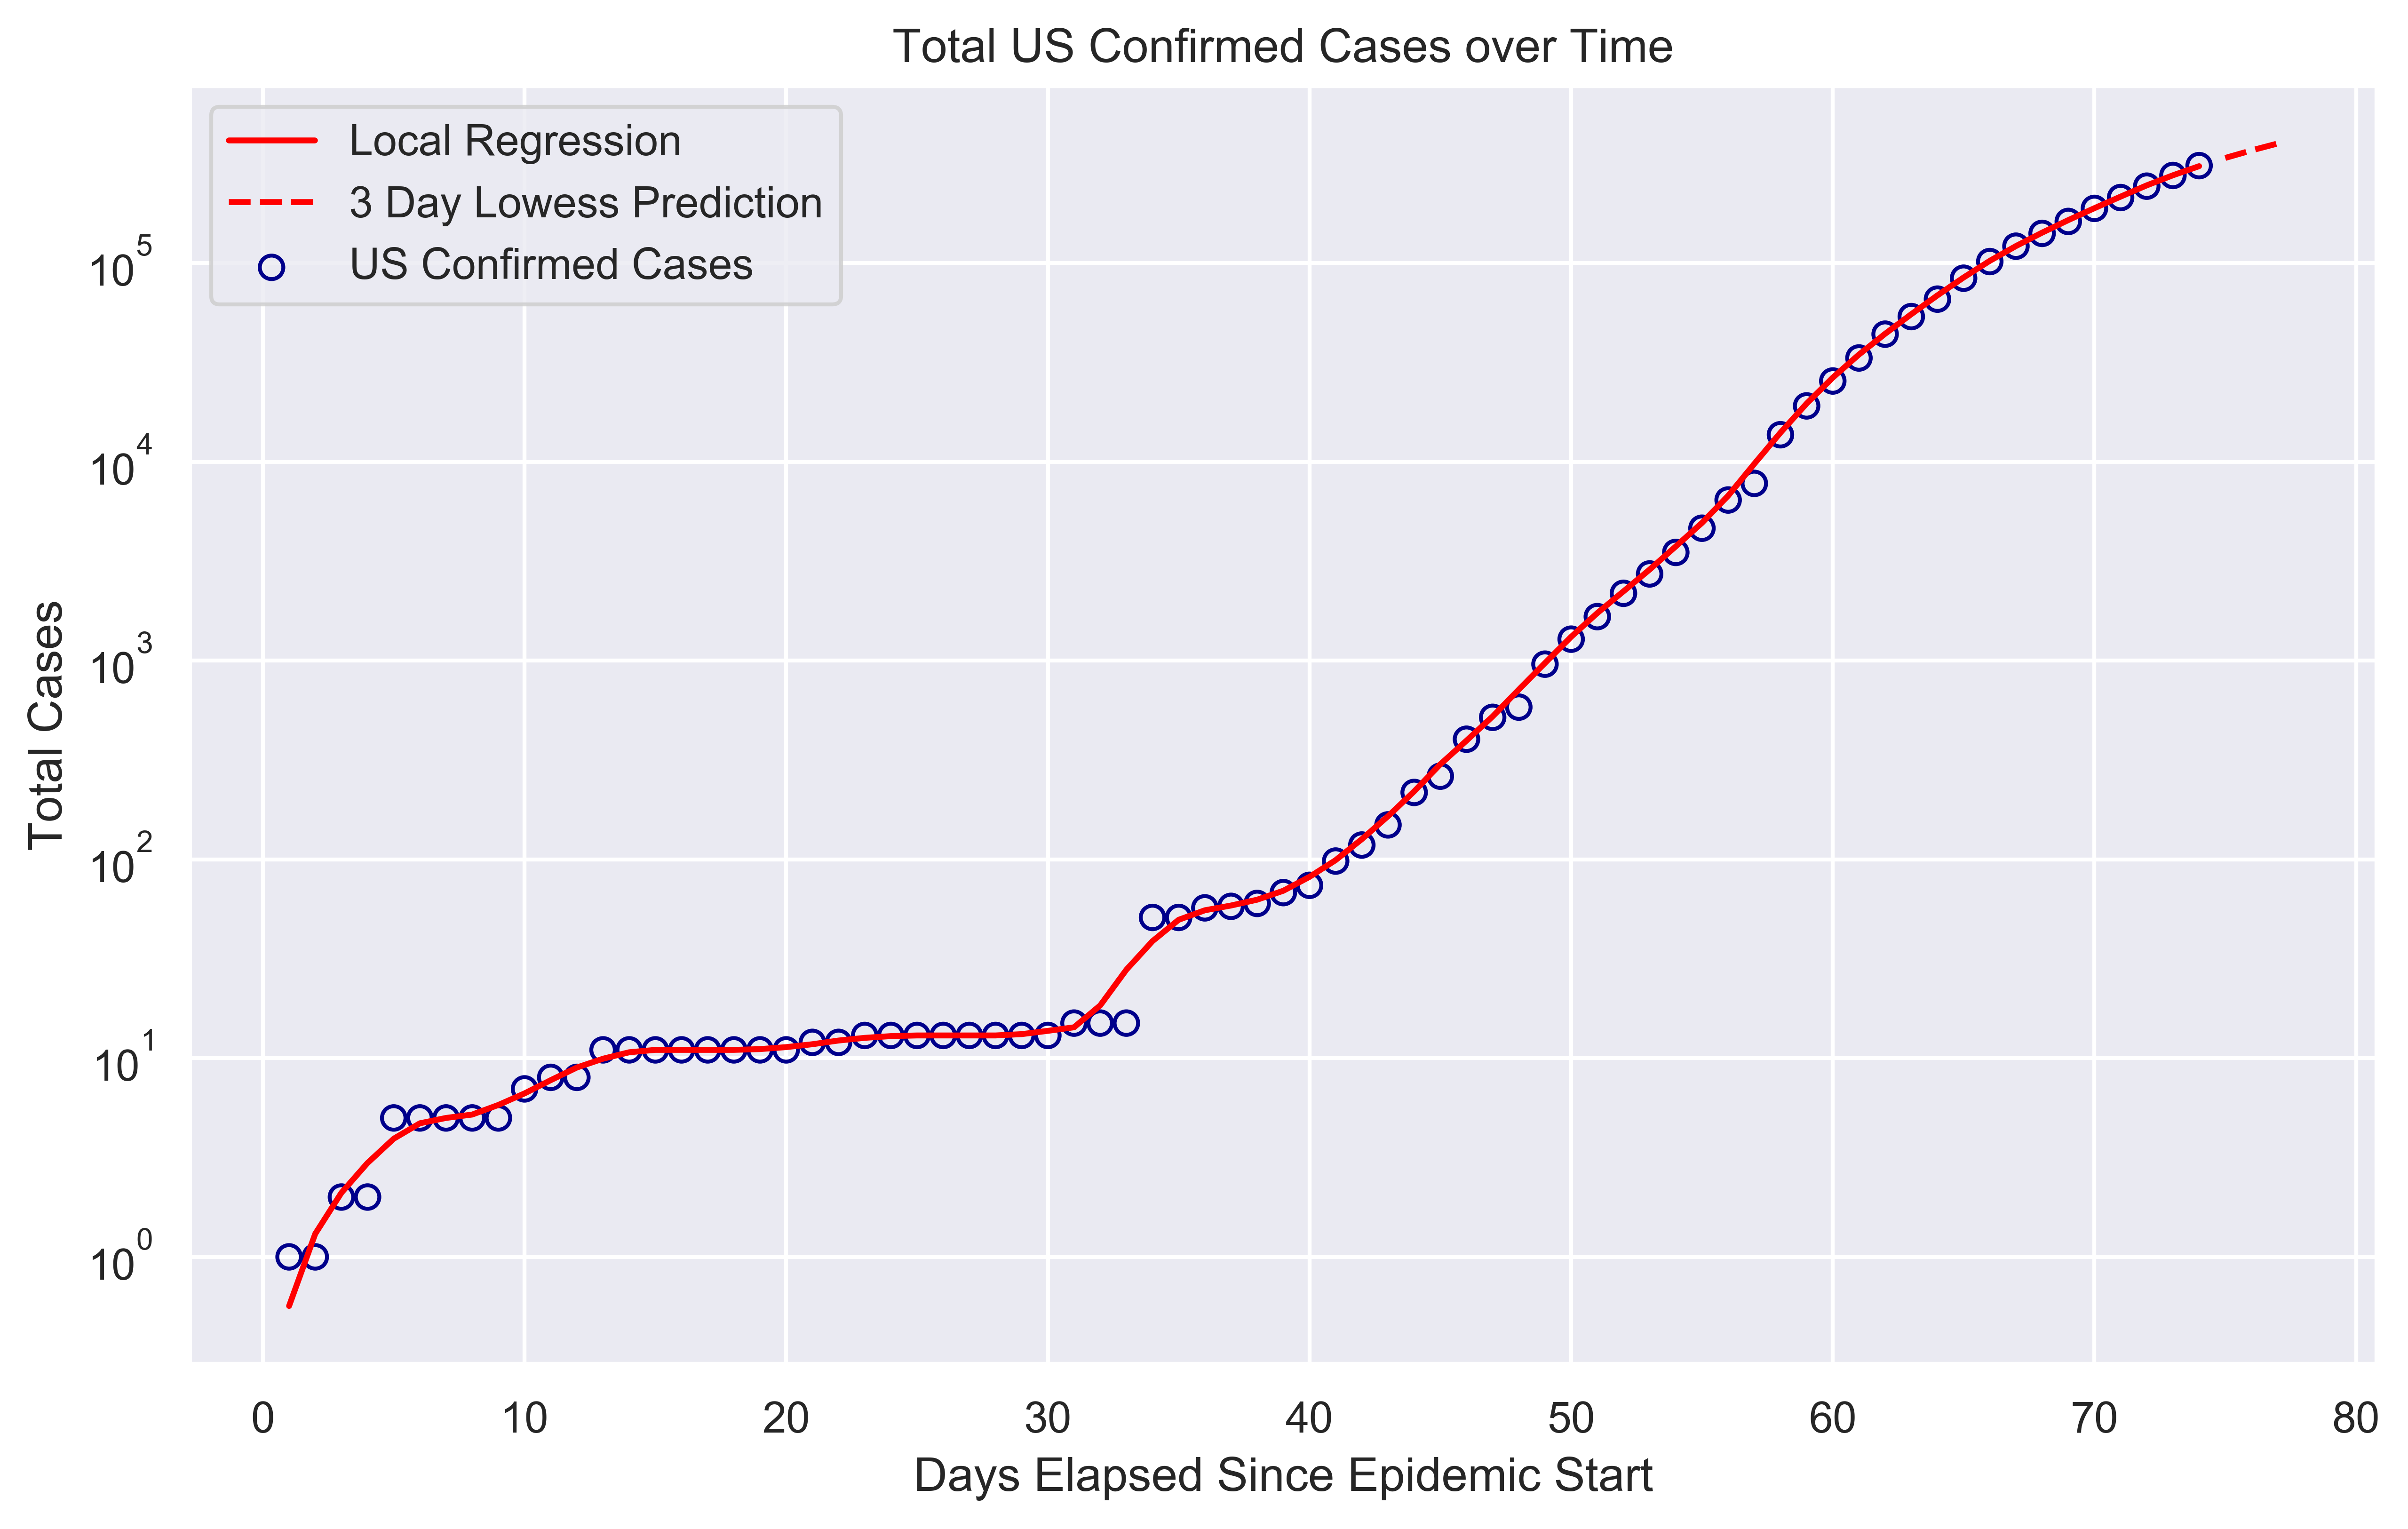

In [9]:
plt.figure(figsize=(10,6))
plt.scatter(x, y, facecolors = 'none', edgecolor = 'darkblue', label = 'US Confirmed Cases')
plt.plot(x, lowess[1], color = 'red', label = 'Local Regression')
# plt.plot(x, exp[1], color = 'orange', label = 'exp')

plt.plot(x_range, y_hat, '--', color = 'red', label = '{} Day Lowess Prediction'.format(d))
# plt.plot(x_extended, y_hat_exp, color = 'orange', label = 'exp')

plt.yscale('log')

plt.legend()
plt.ylabel('Total Cases')
plt.xlabel('Days Elapsed Since Epidemic Start')
plt.title('Total US Confirmed Cases over Time')
plt.show()

### Regression of cases using compounded growth

In [14]:
df_country.loc[df_country.Country == 'US'].tail()

,Country,Date,Confirmed,EpidemicStartDate,DaysElapsed,NewConfirmed,DaysElapsed_Log,Confirmed_Log,NewConfirmed_Log
12658,US,2020-03-31,188172,2020-01-22,70,26365.0,4.248495,12.145112,10.179793
12839,US,2020-04-01,213372,2020-01-22,71,25200.0,4.262680,12.270792,10.134599
13020,US,2020-04-02,243453,2020-01-22,72,30081.0,4.276666,12.402679,10.311649
13201,US,2020-04-03,275586,2020-01-22,73,32133.0,4.290459,12.526655,10.377639
13382,US,2020-04-04,308850,2020-01-22,74,33264.0,4.304065,12.640611,10.412231


In [77]:
US = df_country.loc[df_country.Country == 'US'].loc[df_country.Date > pd.to_datetime('2020-02-01')]
y = US.Confirmed_Log.diff(periods=1).values 
x = US.DaysElapsed.values

In [79]:
params = np.polyfit(x[1:], y[1:], deg=1)
y_hat = np.exp(params[0]) * np.exp(params[1]*x)

In [85]:
y_hat - y

array([       nan, 0.86680591, 1.20052295, 1.21598281, 1.23164175,
       1.24750235, 1.26356719, 1.27983891, 1.29632017, 1.22600229,
       1.32992214, 1.26700564, 1.3643951 , 1.38196524, 1.39976165,
       1.41778722, 1.43604493, 1.45453774, 1.47326871, 1.34914003,
       1.51145736, 1.53092131, 0.32686048, 1.57060439, 1.47960438,
       1.59392435, 1.59816443, 1.52791994, 1.58981344, 1.41503033,
       1.53205512, 1.50663138, 1.38634767, 1.59654575, 1.37987175,
       1.57773862, 1.7366321 , 1.3810261 , 1.6134183 , 1.66644645,
       1.68200643, 1.75305354, 1.75357851, 1.74813405, 1.72818455,
       1.88886219, 1.54425772, 1.8012051 , 1.87411516, 1.92393444,
       1.94286269, 2.04385323, 2.0741166 , 2.06297994, 2.14250517,
       2.18719067, 2.24756122, 2.28817778, 2.30692801, 2.36385111,
       2.38970422, 2.43008722, 2.47299728])

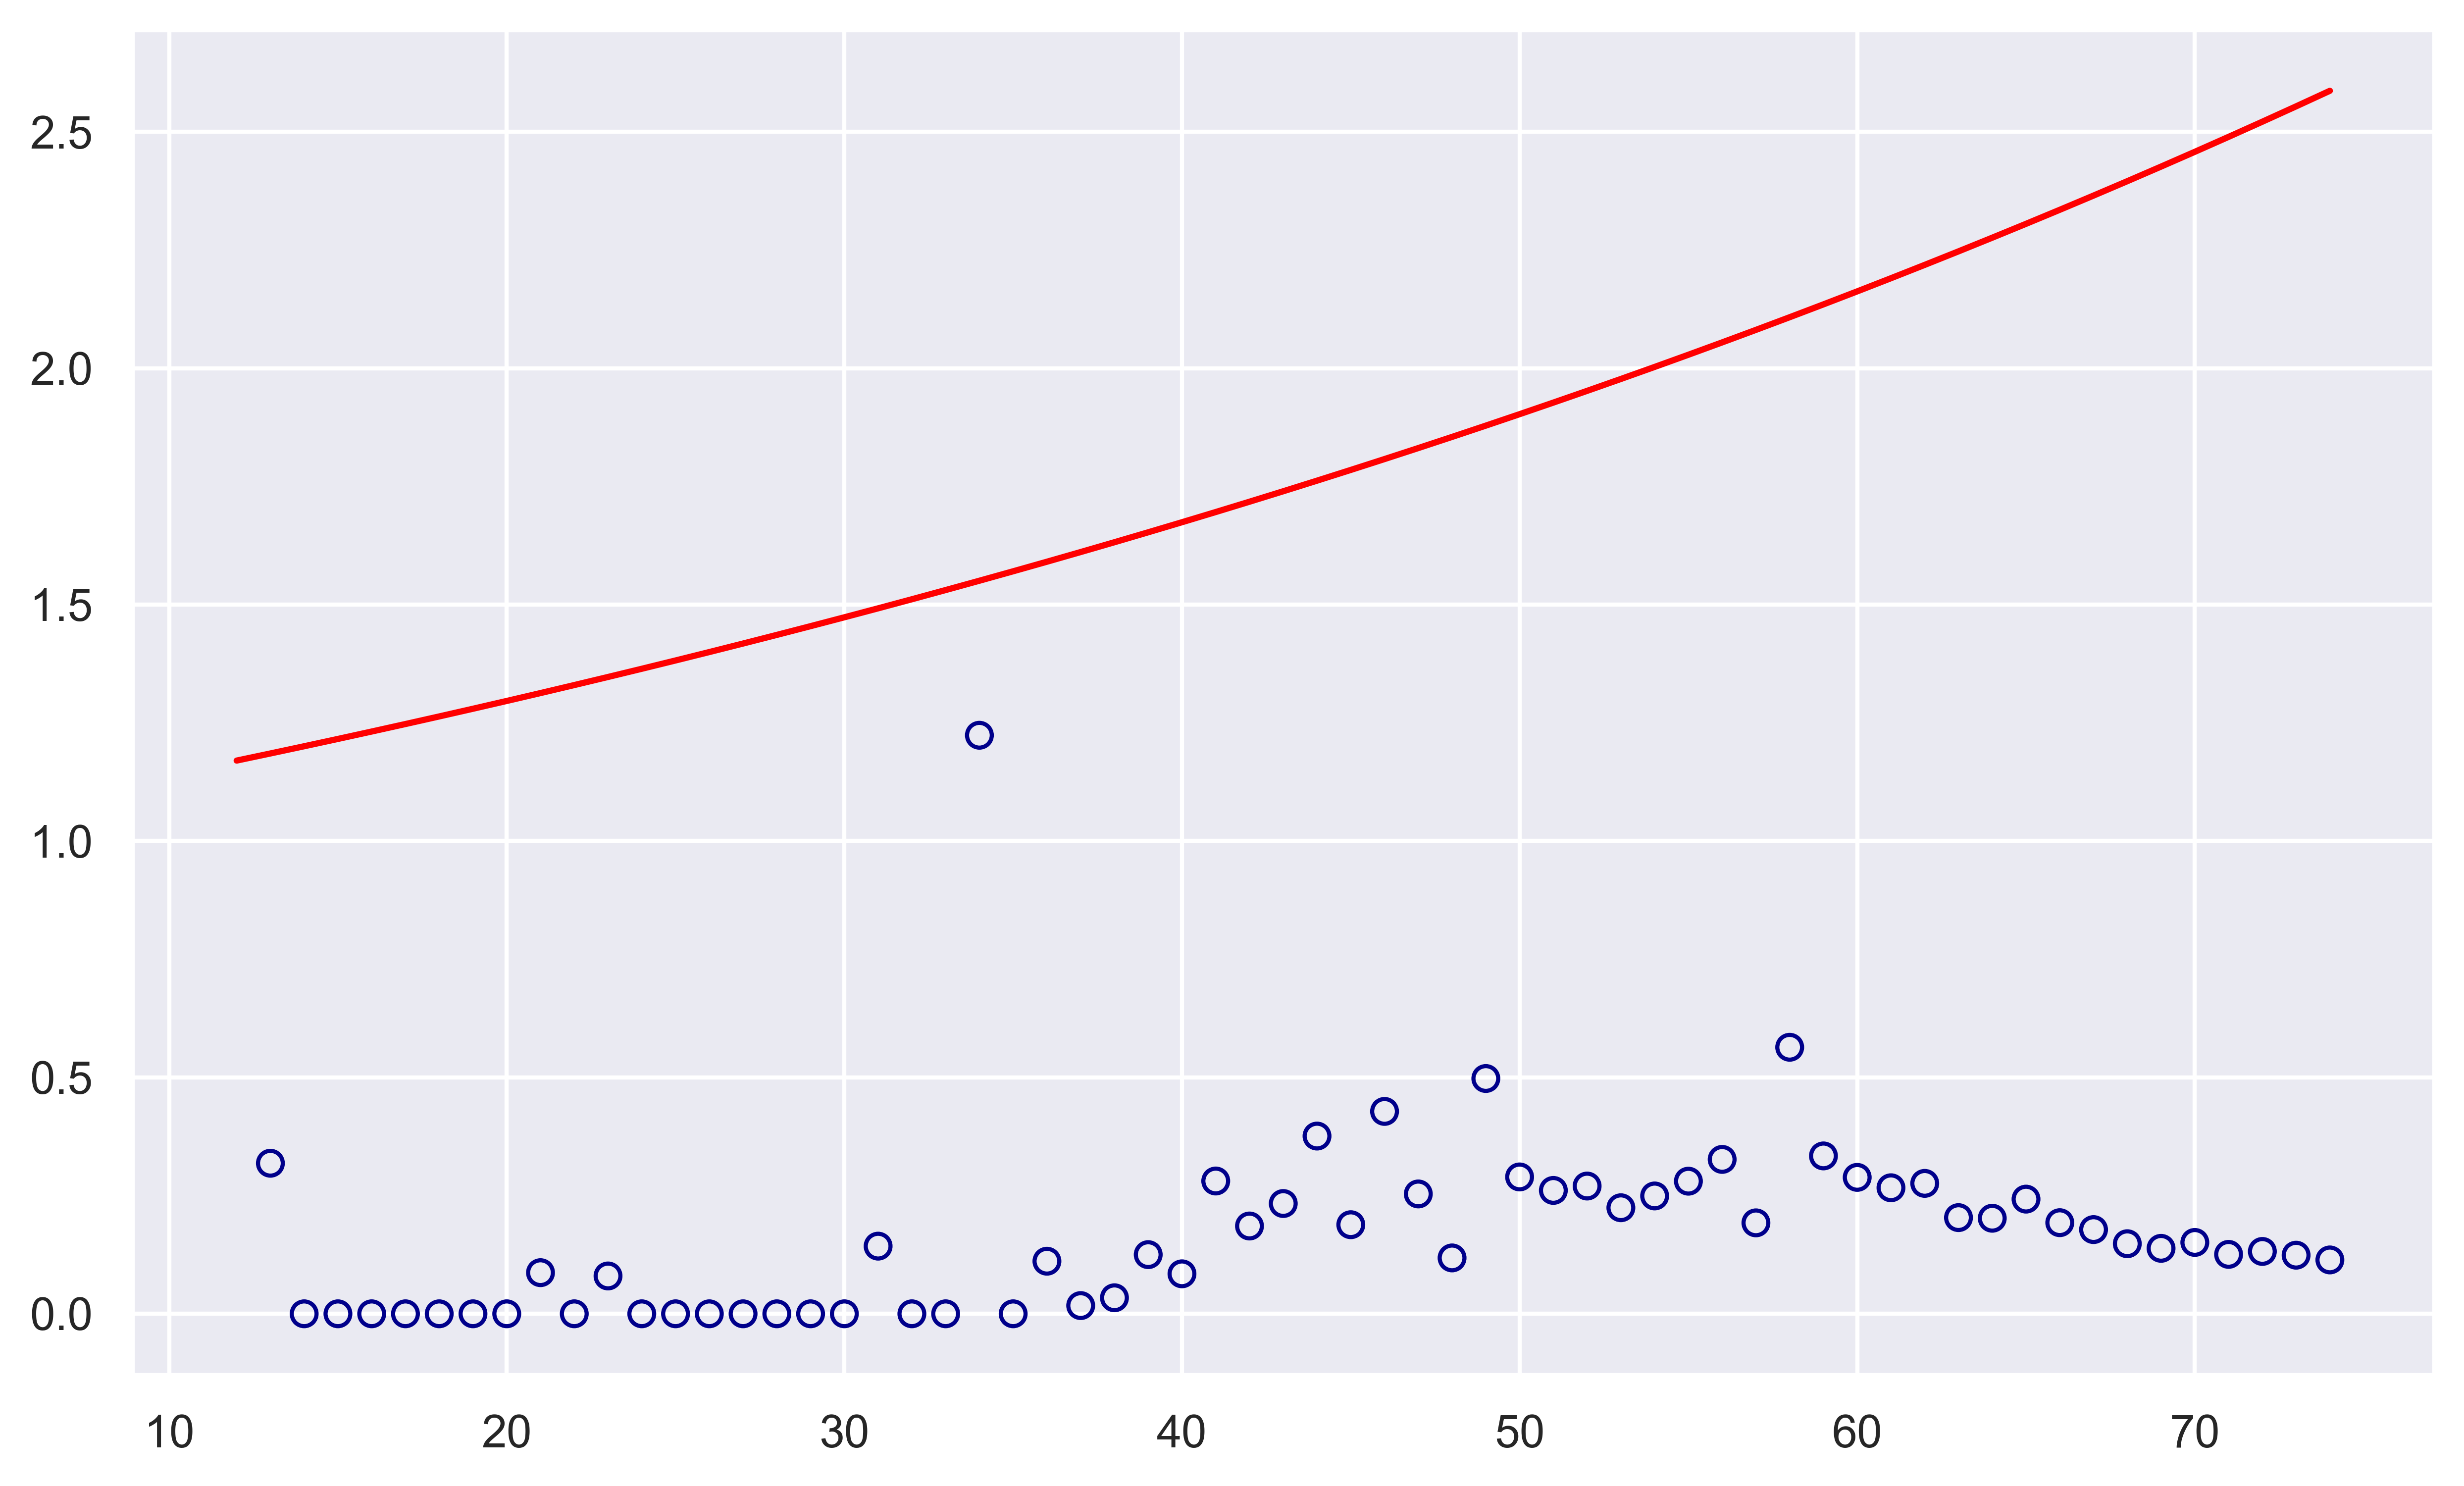

In [82]:
plt.figure(figsize=(10,6))
plt.scatter(x, y, facecolors = 'none', edgecolor = 'darkblue', label = 'US Confirmed Cases')
plt.plot(x, y_hat, color = 'red', label = 'Local Regression')
# plt.plot(x, exp[1], color = 'orange', label = 'exp')a

# plt.plot(x, y_hat, '--', color = 'red', label = '{} Day Lowess Prediction'.format(d))
plt.show()